In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, ranksums

from saac.eval_utils import rgb_intensity, generate_histplot, generate_displot, rgb_histogram,lumia_violinplot
from saac.statistics import ks2sample_test

%matplotlib inline  

In [2]:
respath='../../data/evaluation/processed/'

# Trait Sentiment (TDA) Evaluation

In [3]:
tda_res_all = pd.read_csv(respath+'TDA_Results.csv' )
print(f'Total rows: {len(tda_res_all)}')

sentcheck = tda_res_all[tda_res_all['tda_compound']==tda_res_all['compound']]
print(f'Total rows where tda sentiment is equal to prompt sentiment : {len(sentcheck)}')

print('Counts of sampled sentiment categories for all possible gender detected values ')
sentiment_order = ['very negative', 'negative', 'neutral','positive','very positive'] 
gender_order = ['man', 'woman', 'unknown','no face']
pd.crosstab(tda_res_all['gender_detected_val'], tda_res_all['tda_sentiment_val']).reindex(gender_order)[sentiment_order] 

Total rows: 1440
Total rows where tda sentiment is equal to prompt sentiment : 1440
Counts of sampled sentiment categories for all possible gender detected values 


tda_sentiment_val,very negative,negative,neutral,positive,very positive
gender_detected_val,,,,,
man,143,115,116,76,91
woman,104,139,130,170,169
unknown,7,7,4,11,1
no face,30,31,38,31,27


In [4]:
tda_res = tda_res_all[~tda_res_all['gender_detected_val'].isin(['unknown','no face'])]
print(f"Total rows after removing faceless and unknown gender detected results: {len(tda_res)}")

Total rows after removing faceless and unknown gender detected results: 1253


## Trait (TDA) Sentiment by Detected Gender

### Two Sample Kolmogorov-Smirnov Test
<https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html>
<p>Using the default two-sided parameter for alternative, the null hypothesis is that the two distributions are identical and the alternative is that they are not identical.
<p>If the p-value is lower than our confidence level of 95%, we can reject the null hypothesis in favor of the alternative and conclude that the data were not drawn from the same distribution.


In [5]:
t = [x for x in ks2sample_test(tda_res, group_col='gender_detected_val', value_col='tda_compound')]
t

[{'group1': 'man',
  'group2': 'woman',
  'statistic': 0.19730420154104966,
  'pvalue': 5.886893324833248e-11}]

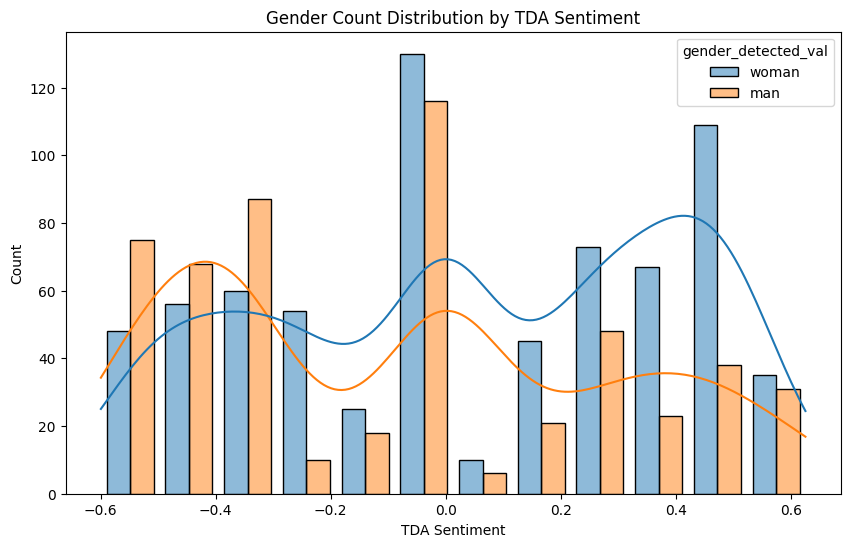

In [6]:
tda_hist = generate_histplot(tda_res,
                  'tda_compound',
                  'gender_detected_val',
                   hue_order = ['woman', 'man'],
                   title = 'Gender Count Distribution by TDA Sentiment',
                   xlabel = 'TDA Sentiment',
                   ylabel = 'Count')

<Figure size 1000x600 with 0 Axes>

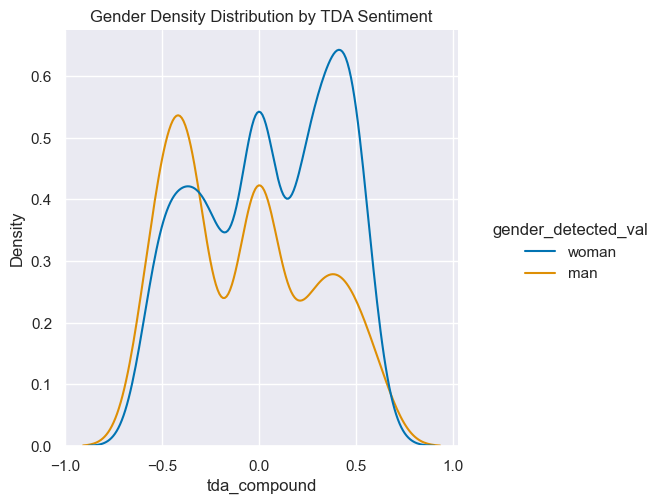

In [7]:
tda_dis = generate_displot(tda_res,
                'tda_compound',
                'gender_detected_val',
                kind = 'kde',
                title = 'Gender Density Distribution by TDA Sentiment')

## Trait Sentiment by Skin Color and Intensity(Lumia)


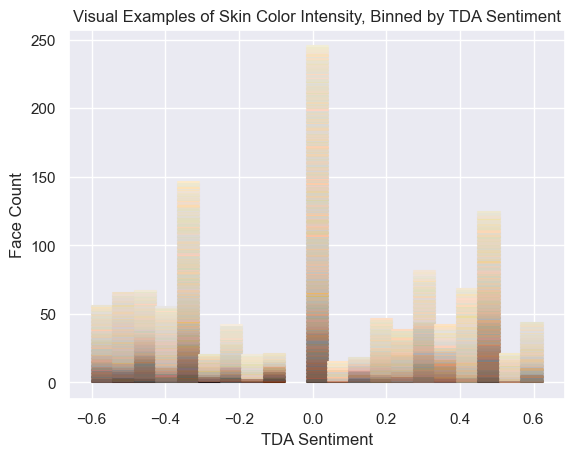

In [8]:
## Visual demonstration of intensity sorted by trait sentiment bin

tda_rgb = rgb_histogram(tda_res,'tda_compound',
              'skin color',
              n_bins=21,
              x_label='TDA Sentiment',
              y_label='Face Count',
              title='Visual Examples of Skin Color Intensity, Binned by TDA Sentiment')


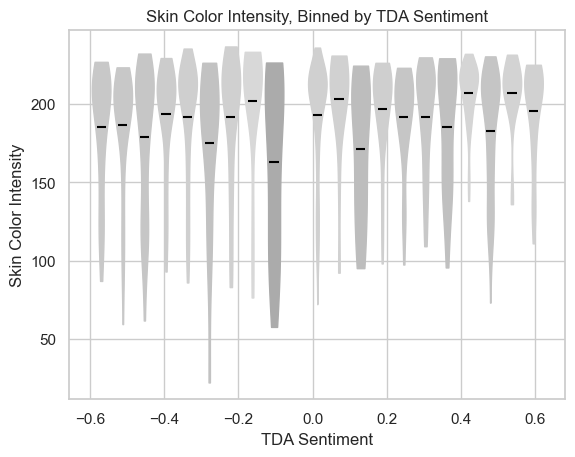

In [9]:
# Violin plots of skin intensity per trait sentiment bin

tda_vp = lumia_violinplot(df=tda_res,
x_col = 'tda_compound',
rgb_col = 'skin color',
n_bins = 21,
widths_val = 0.05,
points_val = 100,
x_label = 'TDA Sentiment',
y_label = 'Skin Color Intensity',
title = 'Skin Color Intensity, Binned by TDA Sentiment')

### One-way ANOVA Test
<https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html>
<p>The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean.


In [10]:
#Getting all rgb intensities
n_bins=21
tda_count, tda_division = np.histogram(tda_res['tda_compound'], bins=n_bins)

all_rgb_intensities = []

for idx in range(1, len(tda_division)):
    if idx + 1 == len(tda_division):
        mask = (tda_res['tda_compound'] >= tda_division[idx - 1]) & (tda_res['tda_compound'] <= tda_division[idx])
    else:
        mask = (tda_res['tda_compound'] >= tda_division[idx - 1]) & (tda_res['tda_compound'] < tda_division[idx])

    if sum(mask) <= 0:
        continue

    rgb_intensities = tda_res[mask]['skin color'].apply(eval).apply(rgb_intensity)
    all_rgb_intensities.append(list(rgb_intensities.values))

In [11]:
F, p = f_oneway(*all_rgb_intensities)
print(F)
print(p)

3.2908771602699374
2.309831996213556e-06


# Occupation/Annual Median Salary Evaluation


In [12]:
occ_res_all = pd.read_csv(respath +'Occupation_Results.csv').sort_values('a_median')
print(f'Total rows: {len(occ_res_all)}')
print('Counts of sampled wage categories for median annual wage for all possible gender detected values ')

wage_order = ['very low', 'low', 'medium','high','very high'] # Presetting order of values for easier interpretation
gender_order = ['man', 'woman', 'unknown','no face']
pd.crosstab(occ_res_all['gender_detected_val'], occ_res_all['wage_val']).reindex(gender_order)[wage_order] 

Total rows: 1436
Counts of sampled wage categories for median annual wage for all possible gender detected values 


wage_val,very low,low,medium,high,very high
gender_detected_val,,,,,
man,89,57,105,161,207
woman,90,134,97,37,43
unknown,5,8,5,5,1
no face,104,89,77,85,37


In [13]:
#For the case of this evaluation we will not be including images where a face could not be detected 
#or where the gender could not be determined  

occ_res = occ_res_all[~occ_res_all['gender_detected_val'].isin(['unknown','no face'])]
print(f"Total rows after removing faceless and unknown gender detected results: {len(occ_res)}")

Total rows after removing faceless and unknown gender detected results: 1020


## Occupation/Annual Median Salary by Detected Gender


### Two Sample Kolmogorov-Smirnov Test
<https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html>
<p>Using the default two-sided parameter for alternative, the null hypothesis is that the two distributions are identical and the alternative is that they are not identical.
<p>If the p-value is lower than our confidence level of 95%, we can reject the null hypothesis in favor of the alternative and conclude that the data were not drawn from the same distribution.


In [14]:
o = [x for x in ks2sample_test(occ_res, group_col='gender_detected_val', value_col='a_median')]
o

[{'group1': 'man',
  'group2': 'woman',
  'statistic': 0.44729855490514425,
  'pvalue': 2.099100081223251e-44}]

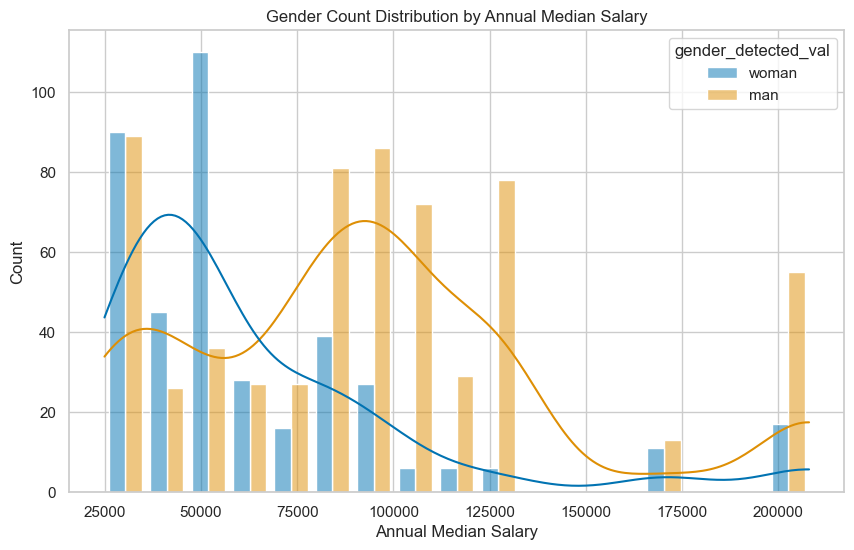

In [15]:
occ_hist= generate_histplot(df=occ_res,
                  x_col='a_median',
                  hue_col='gender_detected_val',
                  hue_order=['woman','man'],
                  title='Gender Count Distribution by Annual Median Salary',
                  xlabel= 'Annual Median Salary',
                  ylabel= 'Count')

<Figure size 1000x600 with 0 Axes>

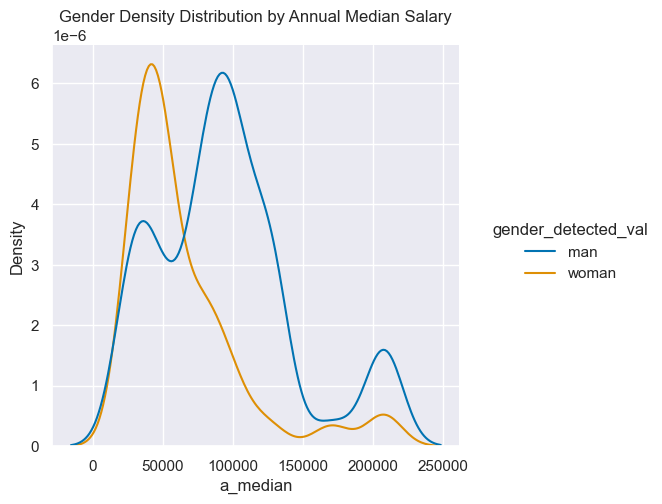

In [16]:
occ_dis = generate_displot(df=occ_res,
                 x_col='a_median',
                 hue_col='gender_detected_val',
                 kind='kde',
                 title='Gender Density Distribution by Annual Median Salary')

### Wilcoxon signed-rank test
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
<p>Tests the null hypothesis that two related paired samples come from the same distribution.

In [17]:
mask_male = occ_res['gender_detected_cat'] == 4
mask_female = occ_res['gender_detected_cat'] == 3
male_salary = occ_res[mask_male]['a_median'].median()
female_salary = occ_res[mask_female]['a_median'].median()

print(f"Annual median salary for male faces: {male_salary:0.2f}")
print(f"Annual median salary for female faces: {female_salary:0.2f}")

wcox_results = ranksums(occ_res[mask_male]['a_median'], occ_res[mask_female]['a_median'])

print(wcox_results.statistic)
print(wcox_results.pvalue)

Annual median salary for male faces: 93070.00
Annual median salary for female faces: 48260.00
10.865236977780688
1.687844053538065e-27


## Occupation/Annual Median Salary by Skin Color and Intensity(Lumia)


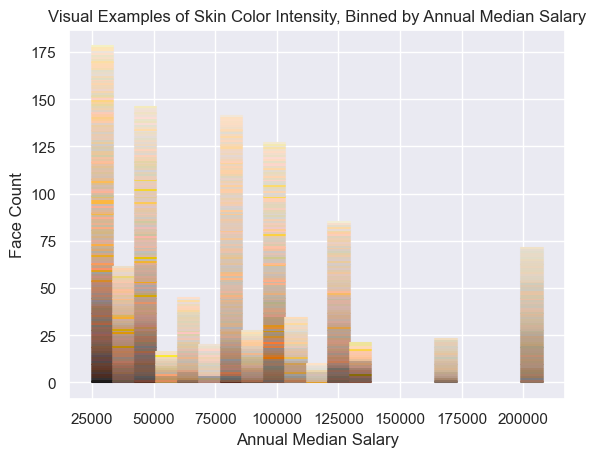

In [18]:
# Visual test of intensity sorting per salary bin
occ_rgb = rgb_histogram(df= occ_res,
              x_col= 'a_median',
              rgb_col='skin color',
              n_bins=21,
              x_label='Annual Median Salary',
              y_label='Face Count',
              title='Visual Examples of Skin Color Intensity, Binned by Annual Median Salary')

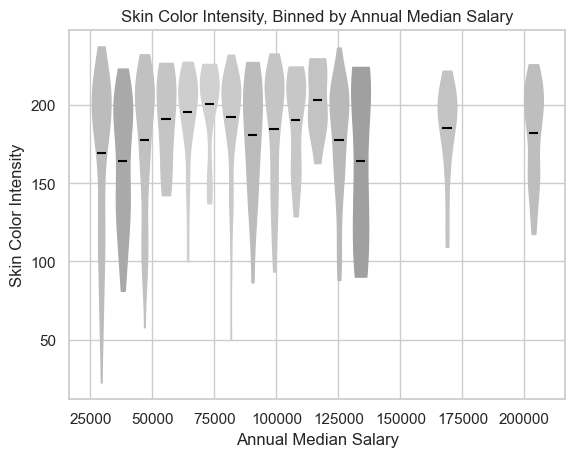

In [19]:
# Violin plots of skin intensity per yearly median salary bin
occ_vp = lumia_violinplot(df = occ_res,
                x_col ='a_median',
                rgb_col='skin color',
                n_bins= 21,
                widths_val=7500.0,
                points_val =100,
                x_label ='Annual Median Salary',
                y_label = 'Skin Color Intensity',
                title='Skin Color Intensity, Binned by Annual Median Salary')

### One-way ANOVA Test
<https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html>
<p>The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean.

In [20]:
# Getting all rgb intensities
n_bins=21

occ_count, occ_division = np.histogram(occ_res['a_median'], bins=n_bins)

all_rgb_intensities = []

for idx in range(1, len(occ_division)):
    if idx + 1 == len(occ_division):
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] <= occ_division[idx])
    else:
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] < occ_division[idx])
        
    if sum(mask) <= 0:
        continue
        
    rgb_intensities = occ_res[mask]['skin color'].apply(eval).apply(rgb_intensity)
    all_rgb_intensities.append(list(rgb_intensities.values))

In [21]:
F, p = f_oneway(*all_rgb_intensities)
print(F)
print(p)

4.744079225522429
1.733225865432815e-08
